## Black Box Interp

### Identity Model

In [1]:
import collections
import copy
import gc
import logging
import math
import os
import pickle
import time
import re
import scipy

import sys
notebook_dir = os.getcwd()
grandparent_dir = os.path.dirname(os.path.dirname(notebook_dir))
sys.path.append(grandparent_dir)
print(sys.path)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as Fn
from tensordict import TensorDict
from pandas.plotting import table
from datetime import datetime

from core import Config
from models import GPT2, CnnKF
from data_train import set_config_params
from create_plots_with_zero_pred import tf_preds
from linalg_helpers import print_matrix
from predictors import getMats, getSims, get_test_data
from run_checkpoints import getPredsEx
from scipy import stats

#set cuda device
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



['/home/sultand/.conda/envs/mop/lib/python312.zip', '/home/sultand/.conda/envs/mop/lib/python3.12', '/home/sultand/.conda/envs/mop/lib/python3.12/lib-dynload', '', '/home/sultand/.local/lib/python3.12/site-packages', '/home/sultand/transformers/src', '/home/sultand/.conda/envs/mop/lib/python3.12/site-packages', '/home/sultand/TFs_do_KF_ICL/src']
/home/sultand/TFs_do_KF_ICL/src/interp/black_box
Using device: cuda
/home/sultand/TFs_do_KF_ICL/src/interp/black_box
Using device: cuda
CUDA_VISIBLE_DEVICES: None
['/home/sultand/.conda/envs/mop/lib/python312.zip', '/home/sultand/.conda/envs/mop/lib/python3.12', '/home/sultand/.conda/envs/mop/lib/python3.12/lib-dynload', '', '/home/sultand/.local/lib/python3.12/site-packages', '/home/sultand/transformers/src', '/home/sultand/.conda/envs/mop/lib/python3.12/site-packages', '/home/sultand/TFs_do_KF_ICL/src', '/home/sultand/TFs_do_KF_ICL/src']
['/home/sultand/.conda/envs/mop/lib/python312.zip', '/home/sultand/.conda/envs/mop/lib/python3.12', '/home

In [3]:
# get model ckpt

model_name = "ident"

if model_name == "ident":
    valA = "ident"
    valC = "_ident_C"
    nx = 5

ckpt_step = 1500 #17600 #100 #1500

config = Config()
output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)

print(f"ckpt_dir: {ckpt_dir}")
print(f"ckpt_path: {config.ckpt_path}")
config.override("ckpt_path", ckpt_dir + f"/checkpoints/step={ckpt_step}.ckpt")
print(f"ckpt_path: {config.ckpt_path}")

num_gpu = len(config.devices)
batch_size = config.batch_size
print(f"Number of GPUs: {num_gpu}")
print(f"Batch size: {batch_size}")
print(f"Number of training examples: {ckpt_step*batch_size*num_gpu}")



IDENTITY MEDIUM MODEL


ckpt_dir: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000
ckpt_path: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=1500.ckpt
ckpt_path: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=1500.ckpt
Number of GPUs: 2
Batch size: 512
Number of training examples: 1536000


In [4]:
#load the model

model = GPT2.load_from_checkpoint(config.ckpt_path,
                                n_dims_in=config.n_dims_in, n_positions=config.n_positions,
                                n_dims_out=config.n_dims_out, n_embd=config.n_embd,
                                n_layer=config.n_layer, n_head=config.n_head, use_pos_emb=config.use_pos_emb, map_location=device, strict=True).eval().to(
    device)

In [5]:
num_sys_haystack = 2

multi_sys_ys, seg_starts_per_config, sys_inds_per_config, sys_dict_per_config, sys_choices_per_config = get_test_data(config, num_sys_haystack, valA, valC, nx)

In [6]:
trace_config = 0
trial = 0
print(f"multi_sys_ys[{trace_config},{trial}].shape: {multi_sys_ys[trace_config,trial].shape}")

sys_inds = sys_inds_per_config[trace_config]
print(f"sys_inds: {sys_inds}")
sys_dict = sys_dict_per_config[trace_config]
print(f"sys_dict: {sys_dict}")
sys_choices = sys_choices_per_config[trace_config]
print(f"sys_choices: {sys_choices}")

final_sys_name = sys_dict[sys_choices[-1]]
print(f"final_sys_name: {final_sys_name}")


final_open_ind = seg_starts_per_config[trace_config][-1]
print(f"final_open_ind: {final_open_ind}")


inserted_payload = None

multi_sys_ys[0,0].shape: (37, 57)
sys_inds: [0 1]
sys_dict: {np.int64(0): np.int64(24), np.int64(1): np.int64(14)}
sys_choices: [np.int64(0), np.int64(1), np.int64(0)]
final_sys_name: 24
final_open_ind: 25


In [ ]:
alpha = 1.0 #1e-2 #0.0 #0.5e-1
alpha_string = f"alpha_{alpha}"
payload_experiment = f"wrong_payload_{alpha_string}" #f"correct_payload_{alpha_string}" #f"wrong_payload_{alpha_string}"
if "random" in payload_experiment:

    #generate a 5d multivariate normal distribution with cov = (1/5)*I

    mean = np.zeros(nx)
    cov = (alpha/nx)*np.eye(nx)
    num_samples = multi_sys_ys.shape[1]
    print(f"num_samples: {num_samples}")
    random_payload = np.random.multivariate_normal(mean, cov, 1)
    print(f"random_payload.shape: {random_payload.shape}")
    #copy the random payload num_samples times
    random_payload = np.tile(random_payload, (num_samples, 1))
    print(f"random_payload.shape: {random_payload.shape}")

    multi_sys_ys[0,:, final_open_ind, -5:] = random_payload
    multi_sys_ys[0,:, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)
    
    if alpha > 0.0:
        inserted_payload = random_payload

elif "correct" in payload_experiment:

# print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")


# Set last 5 elements to the correct values adjust values such that the squared norm is 2

    num_sys = np.size(seg_starts_per_config[trace_config])-1
    q_ind = seg_starts_per_config[trace_config][num_sys] + 1
    true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
    print(f"true_1af.shape: {true_1af.shape}")
    true_1af_norm = np.linalg.norm(true_1af, axis = 1)
    # print(f"true_1af_norm[:, None]: {true_1af_norm[:, None]}")
    correct_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
    multi_sys_ys[trace_config, :, final_open_ind, -5:] = correct_payload
    multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

    if alpha > 0.0:
        inserted_payload = correct_payload

elif "wrong" in payload_experiment:
    # Set last 5 elements to the incorrect values adjust values such that the squared norm is 2
    num_sys = np.size(seg_starts_per_config[trace_config])-1
    q_ind = np.random.choice(seg_starts_per_config[trace_config][1:-1]) + 1
    true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
    print(f"true_1af: {true_1af}")
    true_1af_norm = np.linalg.norm(true_1af, axis = 1)
    wrong_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
    multi_sys_ys[trace_config, :, final_open_ind, -5:] = wrong_payload
    multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

    print(f"wrong_payload[0,:]: {wrong_payload[0,:]}")

    if alpha > 0.0:
        inserted_payload = wrong_payload


print(f"q_ind: {q_ind}")

In [15]:
def alphaExperiment(alpha, multi_sys_ys, model, device, pay_flag, debug=False):
    alpha_string = f"alpha_{alpha}"
    payload_experiment = f"{pay_flag}_payload_{alpha_string}" #f"correct_payload_{alpha_string}" #f"wrong_payload_{alpha_string}"
    if "random" in payload_experiment:

        #generate a 5d multivariate normal distribution with cov = (1/5)*I

        mean = np.zeros(nx)
        cov = (alpha/nx)*np.eye(nx)
        num_samples = multi_sys_ys.shape[1]
        if debug:
            print(f"num_samples: {num_samples}")
        random_payload = np.random.multivariate_normal(mean, cov, 1)
        if debug:
            print(f"random_payload.shape: {random_payload.shape}")
        #copy the random payload num_samples times
        random_payload = np.tile(random_payload, (num_samples, 1))
        if debug:
            print(f"random_payload.shape: {random_payload.shape}")

        multi_sys_ys[0,:, final_open_ind, -5:] = random_payload
        multi_sys_ys[0,:, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)
        
        if alpha > 0.0:
            inserted_payload = random_payload

    elif "correct" in payload_experiment:

    # print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")


    # Set last 5 elements to the correct values adjust values such that the squared norm is 2

        num_sys = np.size(seg_starts_per_config[trace_config])-1
        q_ind = seg_starts_per_config[trace_config][num_sys] + 1
        true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
        if debug:
            print(f"true_1af.shape: {true_1af.shape}")
        true_1af_norm = np.linalg.norm(true_1af, axis = 1)
        # print(f"true_1af_norm[:, None]: {true_1af_norm[:, None]}")
        correct_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
        multi_sys_ys[trace_config, :, final_open_ind, -5:] = correct_payload
        multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

        if alpha > 0.0:
            inserted_payload = correct_payload

    elif "wrong" in payload_experiment:
        # Set last 5 elements to the incorrect values adjust values such that the squared norm is 2
        num_sys = np.size(seg_starts_per_config[trace_config])-1
        q_ind = np.random.choice(seg_starts_per_config[trace_config][1:-1]) + 1
        print(f"q_ind: {q_ind}")
        print(f"trace_config: {trace_config}")
        print(f"multi_sys_ys.shape: {multi_sys_ys.shape}")
        true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
        if debug:
            print(f"true_1af: {true_1af}")
        true_1af_norm = np.linalg.norm(true_1af, axis = 1)
        wrong_payload = np.sqrt(alpha)*true_1af  #/true_1af_norm[:, None]
        multi_sys_ys[trace_config, :, final_open_ind, -5:] = wrong_payload
        multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

        if debug:
            print(f"wrong_payload[0,:]: {wrong_payload[0,:]}")

        if alpha > 0.0:
            inserted_payload = wrong_payload

    elif "negative" in payload_experiment:
        num_sys = np.size(seg_starts_per_config[trace_config])-1
        q_ind = seg_starts_per_config[trace_config][num_sys] + 1
        true_1af = multi_sys_ys[trace_config, :, q_ind, -5:]
        if debug:
            print(f"true_1af.shape: {true_1af.shape}")
        true_1af_norm = np.linalg.norm(true_1af, axis = 1)
        correct_payload = np.sqrt(alpha)*true_1af
        multi_sys_ys[trace_config, :, final_open_ind, -5:] = -correct_payload
        multi_sys_ys[trace_config, :, final_open_ind, int(2*final_sys_name)] = np.sqrt(2-alpha)

        if alpha > 0.0:
            inserted_payload = -correct_payload

    else:
        print("INVALID PAYLOAD TYPE")

    if debug:
        print(f"q_ind: {q_ind}")

    return multi_sys_ys, inserted_payload

In [21]:
trace_config = 0

preds_tf = tf_preds(multi_sys_ys, model, device, config)

tf1af, true1af, avg1af, avg_w_zero1af = getMats(trace_config, seg_starts_per_config, multi_sys_ys, preds_tf)

AttributeError: 'tuple' object has no attribute 'shape'

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

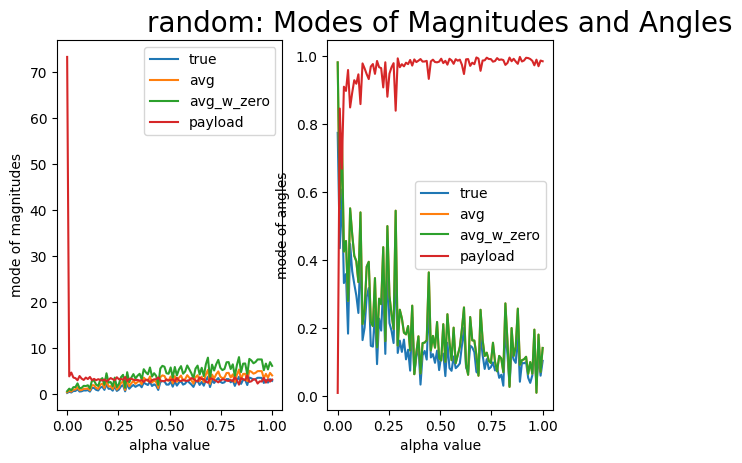

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

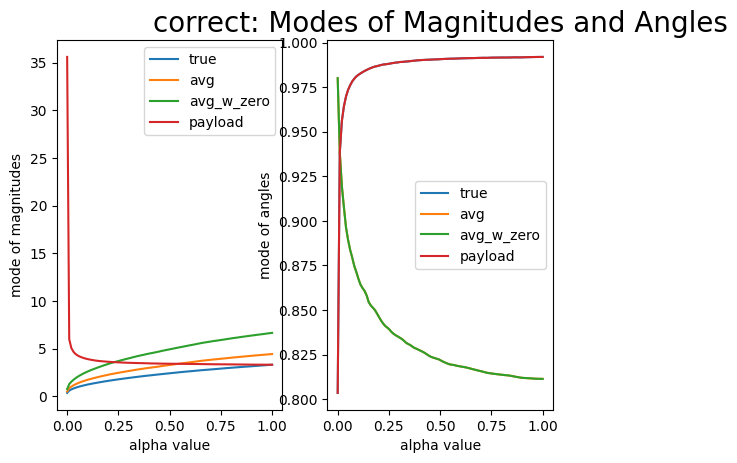

q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.s

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

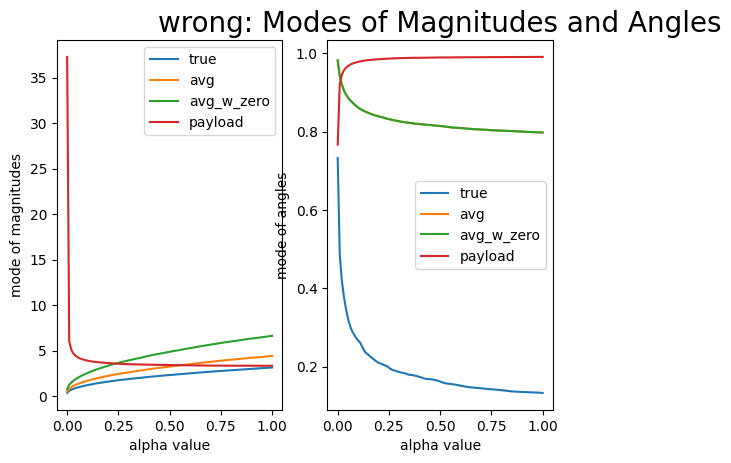

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

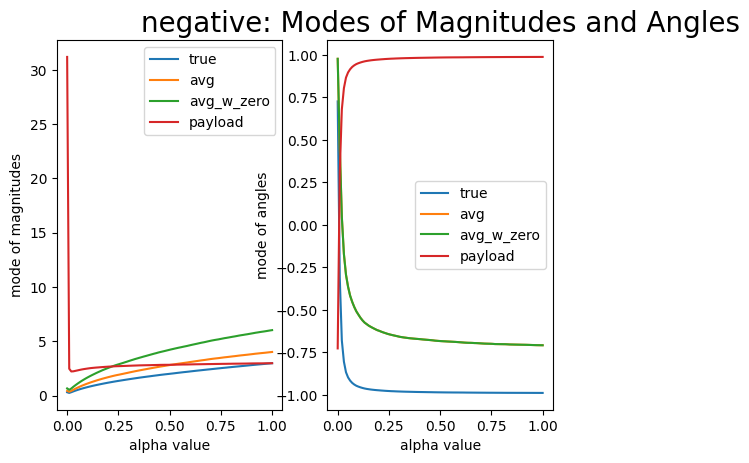

In [17]:
alpha_lst = np.linspace(start = 1e-3, stop = 1, num = 100)
# alpha_lst = [0.5]
#npFunc = lambda x: np.mean(scipy.stats.mode(x))
npFunc = np.median
# npFunc = scipy.stats.mode
pay_lst = ["random", "correct", "wrong", "negative"]

for pay_flag in pay_lst:

  stats = np.zeros((2, 4, len(alpha_lst))) # array containing averaged modes of each system modified by the alpha in alpha_lst
  for i, alpha in enumerate(alpha_lst):
    if alpha == 0.0:
      continue
    # print(f"alpha: {alpha}")
    multi_sys_ys, inserted_payload = alphaExperiment(alpha, multi_sys_ys, model, device, pay_flag, debug=False)
    preds_tf = tf_preds(multi_sys_ys, model, device, config)

    tf1af, true1af, avg1af, avg_w_zero1af = getMats(trace_config, seg_starts_per_config, multi_sys_ys, preds_tf)
    mags, angs = getSims(tf1af, true1af, avg1af, avg_w_zero1af, inserted_payload)
    # print(f"mags.key(): {mags.keys()}")

    stats[0][0][i] = npFunc(mags["true"])
    stats[0][1][i] = npFunc(mags["avg"])
    stats[0][2][i] = npFunc(mags["avg_w_zero"])
    stats[0][3][i] = npFunc(mags["payload"])

    stats[1][0][i] = npFunc(angs["true"])
    stats[1][1][i] = npFunc(angs["avg"])
    stats[1][2][i] = npFunc(angs["avg_w_zero"])
    stats[1][3][i] = npFunc(angs["payload"])

  fig, (ax_mag, ax_ang) = plt.subplots(1,2)

  ax_mag.plot(alpha_lst, stats[0][0], label = "true")
  ax_mag.plot(alpha_lst, stats[0][1], label = "avg")
  ax_mag.plot(alpha_lst, stats[0][2], label = "avg_w_zero")
  ax_mag.plot(alpha_lst, stats[0][3], label = "payload")
  ax_mag.set_ylabel("mode of magnitudes")
  ax_mag.set_xlabel("alpha value")
  ax_mag.legend()


  ax_ang.plot(alpha_lst, stats[1][0], label = "true")
  ax_ang.plot(alpha_lst, stats[1][1], label = "avg")
  ax_ang.plot(alpha_lst, stats[1][2], label = "avg_w_zero")
  ax_ang.plot(alpha_lst, stats[1][3], label = "payload")
  ax_ang.set_ylabel("mode of angles")
  ax_ang.set_xlabel("alpha value")
  ax_ang.legend()

  plt.title(f"{pay_flag}: Modes of Magnitudes and Angles")

  plt.show()

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

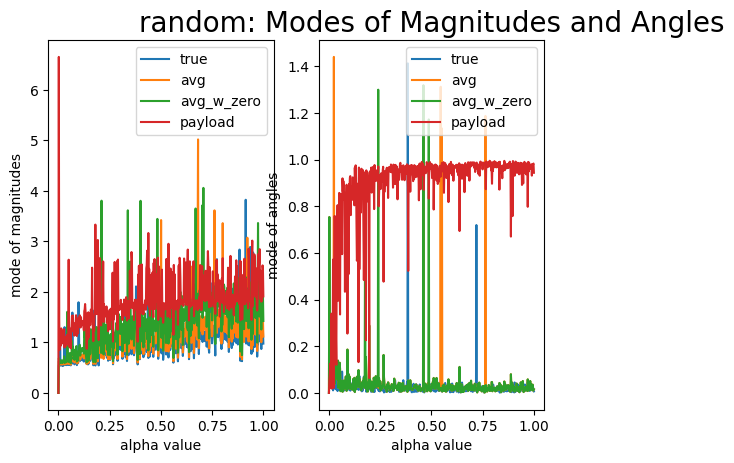

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

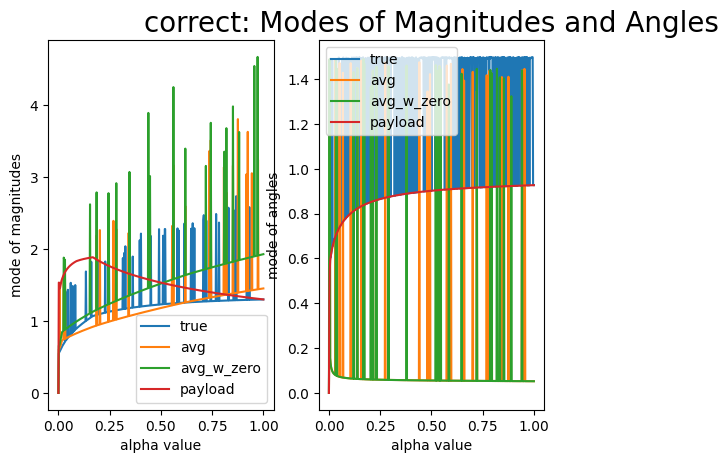

q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.shape: (2, 1000, 37, 57)
q_ind: 14
trace_config: 0
multi_sys_ys.s

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

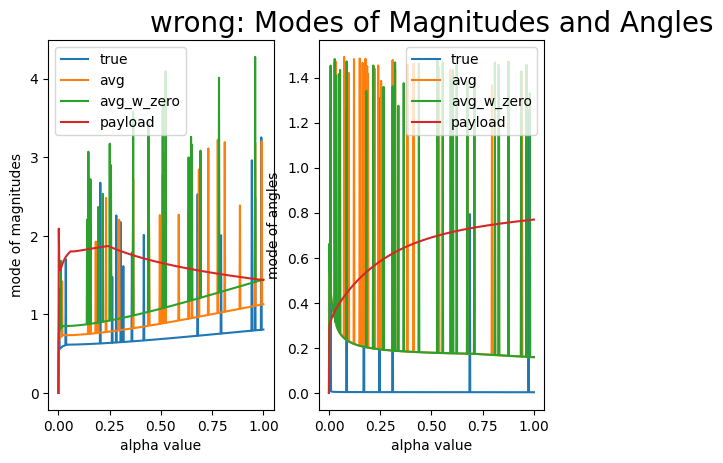

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

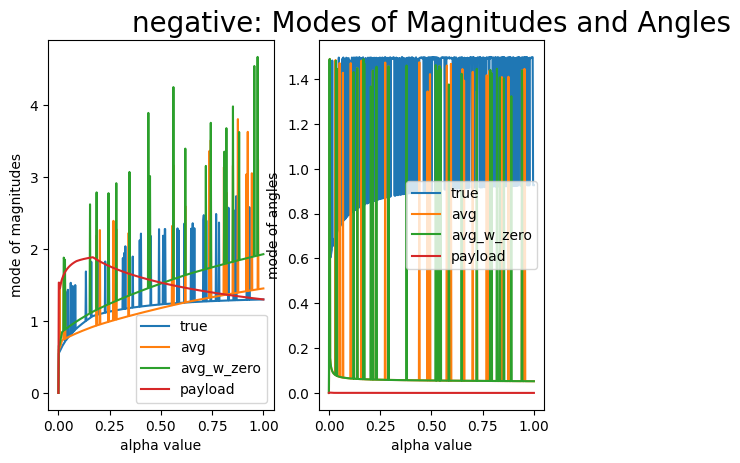

In [ ]:
alpha_lst = np.linspace(start = 0, stop = 1, num = 500)
# alpha_lst = [0.5]
#npFunc = lambda x: np.mean(scipy.stats.mode(x))
npFunc = np.median
# npFunc = scipy.stats.mode
pay_lst = ["random", "correct", "wrong", "negative"]

for pay_flag in pay_lst:

  stats = np.zeros((2, 4, len(alpha_lst))) # array containing averaged modes of each system modified by the alpha in alpha_lst
  for i, alpha in enumerate(alpha_lst):
    if alpha == 0.0:
      continue
    # print(f"alpha: {alpha}")
    multi_sys_ys, inserted_payload = alphaExperiment(alpha, multi_sys_ys, model, device, pay_flag, debug=False)
    preds_tf = tf_preds(multi_sys_ys, model, device, config)

    tf1af, true1af, avg1af, avg_w_zero1af = getMats(trace_config, seg_starts_per_config, multi_sys_ys, preds_tf)
    mags, angs = getSims(tf1af, true1af, avg1af, avg_w_zero1af, inserted_payload)
    # print(f"mags.key(): {mags.keys()}")

    stats[0][0][i] = npFunc(mags["true"])
    stats[0][1][i] = npFunc(mags["avg"])
    stats[0][2][i] = npFunc(mags["avg_w_zero"])
    stats[0][3][i] = npFunc(mags["payload"])

    stats[1][0][i] = npFunc(angs["true"])
    stats[1][1][i] = npFunc(angs["avg"])
    stats[1][2][i] = npFunc(angs["avg_w_zero"])
    stats[1][3][i] = npFunc(angs["payload"])

  fig, (ax_mag, ax_ang) = plt.subplots(1,2)

  ax_mag.plot(alpha_lst, stats[0][0], label = "true")
  ax_mag.plot(alpha_lst, stats[0][1], label = "avg")
  ax_mag.plot(alpha_lst, stats[0][2], label = "avg_w_zero")
  ax_mag.plot(alpha_lst, stats[0][3], label = "payload")
  ax_mag.set_ylabel("mode of magnitudes")
  ax_mag.set_xlabel("alpha value")
  ax_mag.legend()


  ax_ang.plot(alpha_lst, stats[1][0], label = "true")
  ax_ang.plot(alpha_lst, stats[1][1], label = "avg")
  ax_ang.plot(alpha_lst, stats[1][2], label = "avg_w_zero")
  ax_ang.plot(alpha_lst, stats[1][3], label = "payload")
  ax_ang.set_ylabel("mode of angles")
  ax_ang.set_xlabel("alpha value")
  ax_ang.legend()

  plt.title(f"{pay_flag}: Modes of Magnitudes and Angles")

  plt.show()

In [28]:
#### histogram

# adjust for number of bins, same for all plots
num_bins = 100

#### data is in a 10000 x 5 matrix, each column is a different state variable
dummy_tf = np.random.rand(1000)
dummy_avg = np.random.rand(1000)
dummy_zero = np.random.rand(1000)

mags, angs = getSims(tf1af, true1af, avg1af, avg_w_zero1af, inserted_payload)

# convert angs to degrees ranging from 0 to 180
for key in angs:
    cosvals = angs[key]
    angs[key] = np.arccos(cosvals)*180/np.pi

plot_path = f"../../../outputs/interp/black_box/plots/{model_name}/"

os.makedirs(plot_path, exist_ok=True)



# Histogram for Magnitudes
fig, ax = plt.subplots(figsize=(10, 5))

mags_all = np.concatenate([
    mags["true"], 
    mags["avg"], 
    mags["avg_w_zero"]
])
if inserted_payload is not None:
    mags_all = np.concatenate([
        mags_all, 
        mags["payload"]
    ])
mags_edges = np.histogram_bin_edges(mags_all, bins=num_bins)

ax.hist(mags["true"], bins=mags_edges, alpha=0.5, label='true')
ax.hist(mags["avg"], bins=mags_edges, alpha=0.5, label='avg')
ax.hist(mags["avg_w_zero"], bins=mags_edges, alpha=0.5, label='avg_w_zero')
if inserted_payload is not None:
    ax.hist(mags["payload"], bins=mags_edges, alpha=0.5, label=payload_experiment)

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of tf, avg, and zero predictions: Ratio of Magnitudes')
ax.legend()
ax.grid(True)
# set minor ticks of interval 1
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
fig.tight_layout()
plt.show()
fig.savefig(f"{plot_path}hist_mags_ckpt_{ckpt_step}_{payload_experiment}.pdf", bbox_inches='tight', format='pdf')

# Histogram for Angles
fig, ax = plt.subplots(figsize=(10, 5))

angs_all = np.concatenate([
    angs["true"], 
    angs["avg"], 
    angs["avg_w_zero"]
])
if inserted_payload is not None:
    angs_all = np.concatenate([
        angs_all, 
        angs["payload"]
    ])
angs_edges = np.histogram_bin_edges(angs_all, bins=num_bins)

ax.hist(angs["true"], bins=angs_edges, alpha=0.5, label='true')
ax.hist(angs["avg"], bins=angs_edges, alpha=0.5, label='avg')
ax.hist(angs["avg_w_zero"], bins=angs_edges, alpha=0.5, label='avg_w_zero')
if inserted_payload is not None:
    ax.hist(angs["payload"], bins=angs_edges, alpha=0.5, label=payload_experiment)

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of tf, avg, and zero predictions: Angles')
ax.legend()
ax.grid(True)
plt.show()
fig.savefig(f"{plot_path}hist_angles_ckpt_{ckpt_step}_{payload_experiment}.pdf", bbox_inches='tight', format='pdf')

# Histogram for tf magnitudes
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(np.linalg.norm(tf1af, axis=1), bins=num_bins, alpha=0.5, label='tf mag')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_xlim(0, 1)
plt.show()


In [6]:
num_sys_haystack = 2
multi_sys_ys, seg_starts_per_config, sys_inds_per_config, sys_dict_per_config, sys_choices_per_config = get_test_data(config, num_sys_haystack, valA, valC, nx)
model_preds, ckpt_lst = getPredsEx(device, multi_sys_ys, nx, num_sys_haystack, model_name, 17600, debug=True)

Ckpt path /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=100.ckpt found.


IDENTITY MEDIUM MODEL


Checkpoint Path: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/checkpoints/step=100.ckpt
Output Directory: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000
Checkpoint Directory: /data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000
Batch size: 512
Number of GPUs: 2
Number of training examples: 102400
model: GPT2(
  (_read_in): Linear(in_features=57, out_features=128, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 128)
    (wpe): Embe

In [4]:
print(f"model_preds.shape: {model_preds.shape}")


model_preds.shape: (61, 2, 1000, 37, 5)


In [5]:
# tf1after
trace_config = 0
q_ind = seg_starts_per_config[trace_config][-1] + 1
print(f"model_preds: {model_preds[0,0,0,q_ind,0]} model_preds next: {model_preds[60,0,0,q_ind,0]}")
# print(f"q_ind: {q_ind}")

tf1af = model_preds[:,trace_config, :, q_ind, :]
print(f"tf1af[0,0,0,0,0]: {tf1af[0,0,0]}, tf1af[1,0,0,]: {tf1af[1,0,0]}")
print(f"tf1af: {tf1af}")
tf1af_norm_square = np.linalg.norm(tf1af, axis = -1)**2
print(f"tf1af_norm_square: {tf1af_norm_square}")
# print(f"tf1af_norm_square.shape: {tf1af_norm_square.shape}")
norm_median = np.median(tf1af_norm_square, axis = 1)
# print(f"norm_median.shape: {norm_median.shape}")
# print(f"norm_median: {norm_median}")

train_ex = ckpt_lst*batch_size*num_gpu
# print(f"train_ex: {train_ex}")

# fig,ax = plt.subplots(figsize=(10, 5))
# ax.plot(train_ex, norm_median, label = "tf1af")

print(f"tf1af.shape: {tf1af.shape}")




model_preds: 0.02749226987361908 model_preds next: 0.02749226987361908
tf1af[0,0,0,0,0]: 0.02749226987361908, tf1af[1,0,0,]: 0.02749226987361908
tf1af: [[[ 0.02749227 -0.2367303   0.01120716 -0.21270269  0.1608923 ]
  [ 0.07985581  0.0255038  -0.12242876  0.06659252 -0.04069884]
  [-0.04805312 -0.20763505 -0.12300254 -0.05273076  0.2873314 ]
  ...
  [-0.33185637 -0.09339476 -0.30114603 -0.20861283  0.06779863]
  [-0.10387927  0.25844008 -0.03537014 -0.03710329  0.01019916]
  [-0.00470141 -0.28903776 -0.07527545  0.07341995  0.14222048]]

 [[ 0.02749227 -0.2367303   0.01120716 -0.21270269  0.1608923 ]
  [ 0.07985581  0.0255038  -0.12242876  0.06659252 -0.04069884]
  [-0.04805312 -0.20763505 -0.12300254 -0.05273076  0.2873314 ]
  ...
  [-0.33185637 -0.09339476 -0.30114603 -0.20861283  0.06779863]
  [-0.10387927  0.25844008 -0.03537014 -0.03710329  0.01019916]
  [-0.00470141 -0.28903776 -0.07527545  0.07341995  0.14222048]]

 [[ 0.02749227 -0.2367303   0.01120716 -0.21270269  0.1608923 ]


In [13]:
print(f"model: {model}")

